In [1]:
import os
import cmdstanpy
from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import describe, gaussian_kde, norm, expon
import multiprocessing
import seaborn as sns
import warnings
import time

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 14

In [3]:
from thinning import sample_hawkes_process_thinning_true_vectorised
from utils import exp_kernel_vectorised, constant_background, plot_counting_process
from mle import log_likelihood
from utils import trace_plots, posterior_histograms, posterior_kdes_overlaid, stacked_credible_intervals

In [4]:
np.random.SeedSequence()

SeedSequence(
    entropy=118001356956106415312532913909737627916,
)

## Increasing period of observation

Now we will investigate how our inference improves as we increase the window of observation.

To simplify things, we will fix mu and alpha as their true values and only perform inference on delta.

### Checking sensible max_T values

In [4]:
stan_file = os.path.join('.', 'models', 'exponential_priors_delta_only.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

17:05:59 - cmdstanpy - INFO - compiling stan file C:\Users\ethan\ONEDRI~1\Maths\YEAR4~1\Project\HAWKES~1\BAYESI~1\models\exponential_priors_delta_only.stan to exe file C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\models\exponential_priors_delta_only.exe
17:06:18 - cmdstanpy - INFO - compiled model executable: C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\bayesian_clean\models\exponential_priors_delta_only.exe


In [6]:
hawkes_seed=81123867819014675093953765794895738137

max_T = 400
hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=hawkes_seed)
N = len(hawkes_realisation)

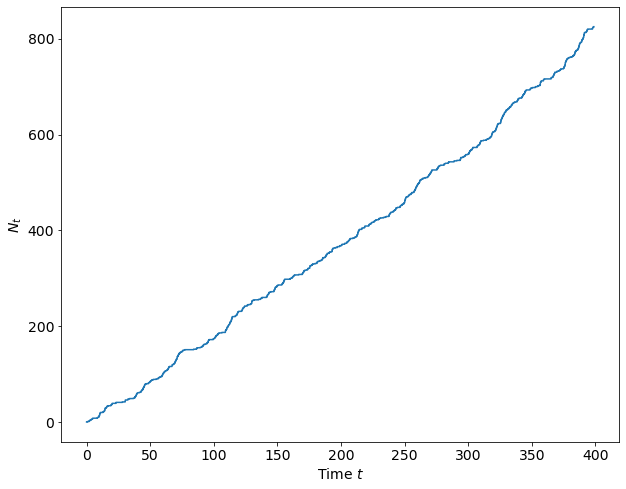

In [7]:
plot_counting_process(hawkes_realisation)

In [8]:
data = {
    "N" : N,
    "events_list" : hawkes_realisation,
    "max_T" : max_T
}

In [9]:
warmup = 250

fit = model_compiled.sample(data=data,
                            seed=123,
                            chains=2,
                            parallel_chains=2,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            inits="0",
                            save_warmup=True)

17:06:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:09:48 - cmdstanpy - INFO - CmdStan done processing.


In [10]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-139.29500,0.023303,0.675844,-140.65200,-139.03000,-138.84800,841.134,3.58752,0.99973
delta,1.98777,0.005119,0.115469,1.79445,1.98556,2.18267,508.812,2.17014,1.00037


In [11]:
print(fit.diagnose())

Processing csv files: C:\Users\ethan\AppData\Local\Temp\tmp3493fqb0\exponential_priors_delta_onlyw_w599rk\exponential_priors_delta_only-20240422170656_1.csvWarning: non-fatal error reading adaptation data
, C:\Users\ethan\AppData\Local\Temp\tmp3493fqb0\exponential_priors_delta_onlyw_w599rk\exponential_priors_delta_only-20240422170656_2.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



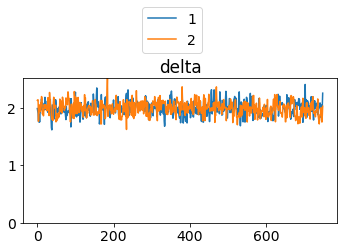

In [14]:
trace_plots([fit], ['delta'], legend_height=1.2)

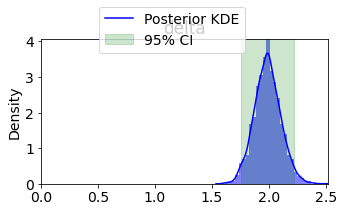

In [15]:
posterior_histograms([fit], ['delta'])

In [32]:
T = 100
index = np.searchsorted(hawkes_realisation, T)
h = hawkes_realisation[:index]
n = len(h)

data = {
    "N" : n,
    "events_list" : h,
    "max_T" : T
}

In [33]:
warmup = 250

fit = model_compiled.sample(data=data,
                            seed=123,
                            chains=2,
                            parallel_chains=2,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            inits="0",
                            save_warmup=True)

17:15:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:15:18 - cmdstanpy - INFO - CmdStan done processing.


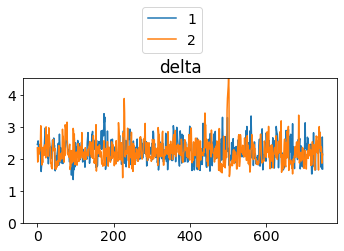

In [36]:
trace_plots([fit], ['delta'], legend_height=1.2)

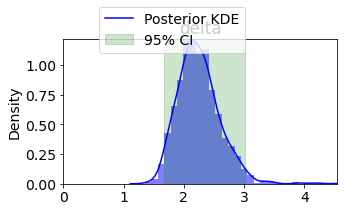

In [37]:
posterior_histograms([fit], ['delta'])

In [38]:
hawkes_seed=81123867819014675093953765794895738137

max_T = 500
hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=hawkes_seed)
N = len(hawkes_realisation)

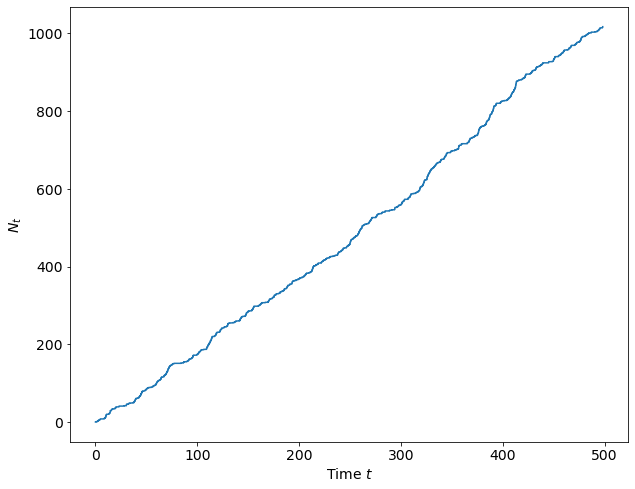

In [42]:
plot_counting_process(hawkes_realisation)

In [43]:
data = {
    "N" : N,
    "events_list" : hawkes_realisation,
    "max_T" : max_T
}

In [44]:
warmup = 250

fit = model_compiled.sample(data=data,
                            seed=123,
                            chains=2,
                            parallel_chains=2,
                            iter_warmup=warmup,
                            iter_sampling=3*warmup,
                            inits="0",
                            save_warmup=True)

17:17:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:21:52 - cmdstanpy - INFO - CmdStan done processing.


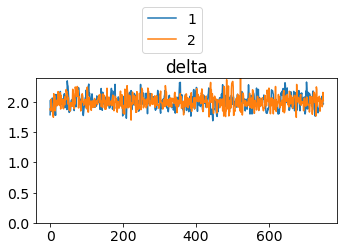

In [45]:
trace_plots([fit], ['delta'], legend_height=1.2)

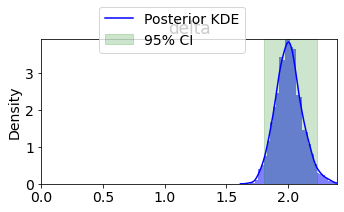

In [46]:
posterior_histograms([fit], ['delta'])

### Now doing for multiple realisations

For ease, we will run each value of max_T separately. Shouldn't be too much effort.

We will just make sure to re-use the seeds for generating the realisations and doing the MCMC sampling

#### max_T=100

In [5]:
max_T = 100
num_samples = 10
hawkes_realisations = []

master_seed = 37789148086743724264404479032151903001
seed_seq_master = np.random.SeedSequence(master_seed)

for i in range(num_samples):

    child_seed = seed_seq_master.spawn(1)[0]

    hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=child_seed)
    hawkes_realisations.append(hawkes_realisation)

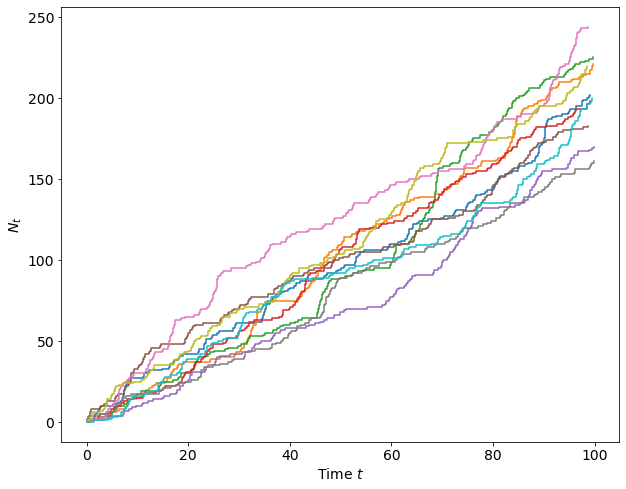

In [6]:
for h in hawkes_realisations:
    h = [0] + h
    counts = np.arange(len(h))
    plt.step(h, counts, where='post')
plt.xlabel("Time $t$")
plt.ylabel("$N_t$")
plt.show()

In [7]:
data_list = [{
    "N" : len(h),
    "events_list" : h,
    "max_T" : max_T
} for h in hawkes_realisations]

In [8]:
warmup = 250

master_seed_stan = 43526238385608073352718321501689842867
seed_seq_master_stan = np.random.SeedSequence(master_seed_stan)

fits = []

save_dir = os.path.join('.', 'saved_fits', 'exponential_priors_delta_only', f'max_T={max_T}')

# for i in range(num_samples):
#     print(f"MCMC sampling for realisation {i}")

#     child_seed_stan = seed_seq_master_stan.spawn(1)[0]

#     # Create a random number generator using the seed
#     rng = np.random.default_rng(child_seed_stan)
    
#     # Generate random integers less than 2**32 - 1
#     child_seed = rng.integers(2**32 - 1)
#     print(f"Child seed used = {child_seed}")

#     save_path = os.path.join(save_dir, f"realisation{i}")
#     print(f"Saving to {save_path}")

#     fit = model_compiled.sample(data=data_list[i],
#                                 seed=child_seed,
#                                 chains=2,
#                                 parallel_chains=2,
#                                 iter_warmup=warmup,
#                                 iter_sampling=3*warmup,
#                                 inits="0",
#                                 save_warmup=True,
#                                 output_dir=save_path)
    
#     fits.append(fit)

In [9]:
for i in range(num_samples):
    save_path = os.path.join(save_dir, f"realisation{i}")
    fit = cmdstanpy.from_csv(save_path)
    fits.append(fit)

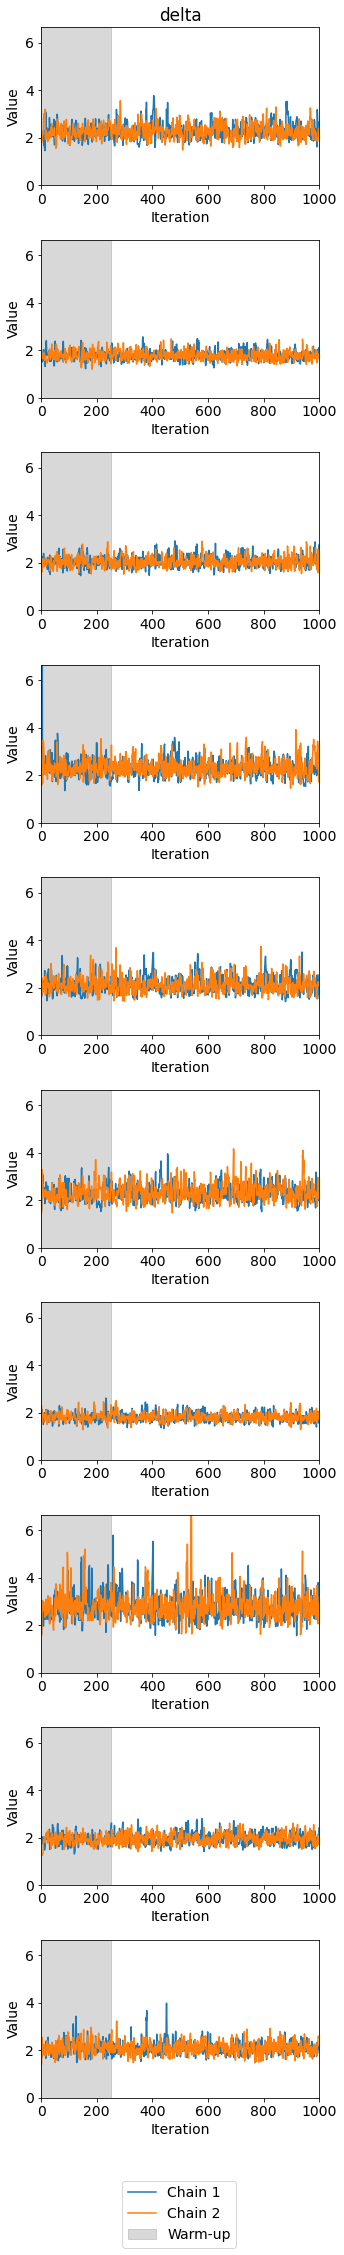

In [11]:
trace_plots(fits, ['delta'], warmup=warmup)

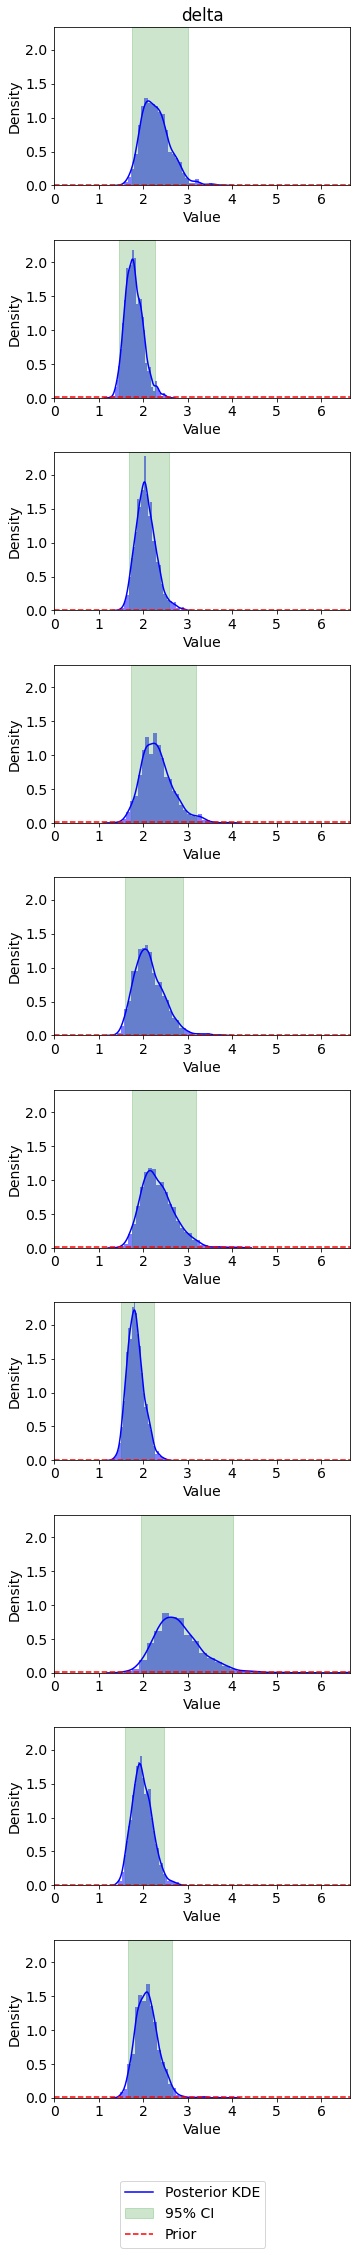

In [12]:
posterior_histograms(fits, ['delta'], [lambda x: expon.pdf(x, scale=1/0.01)])

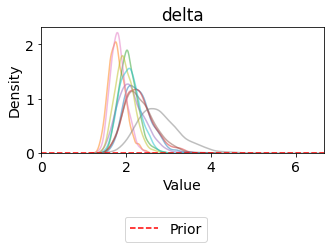

In [13]:
posterior_kdes_overlaid(fits, ['delta'], [lambda x: expon.pdf(x, scale=1/0.01)])

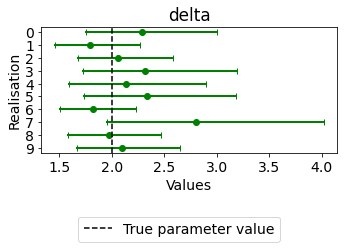

In [21]:
stacked_credible_intervals(fits, ['delta'], [2])
# stacked_credible_intervals(fits, ['delta'], [2], [stats.expon.interval(0.95, scale=1/0.01)])

#### max_T=200

In [22]:
max_T = 200
num_samples = 10
hawkes_realisations = []

master_seed = 37789148086743724264404479032151903001
seed_seq_master = np.random.SeedSequence(master_seed)

for i in range(num_samples):

    child_seed = seed_seq_master.spawn(1)[0]

    hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=child_seed)
    hawkes_realisations.append(hawkes_realisation)

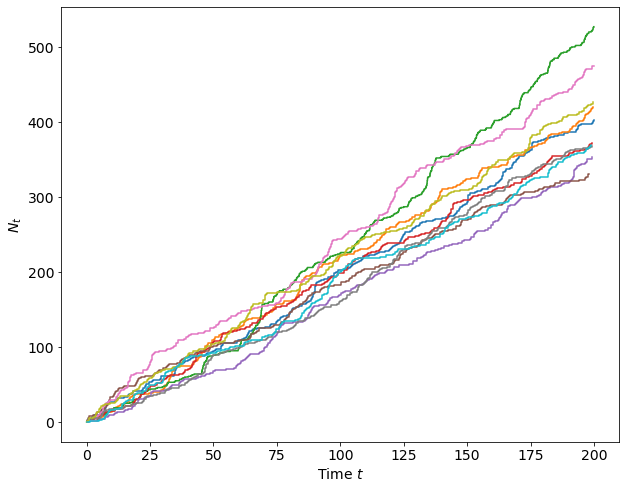

In [23]:
for h in hawkes_realisations:
    h = [0] + h
    counts = np.arange(len(h))
    plt.step(h, counts, where='post')
plt.xlabel("Time $t$")
plt.ylabel("$N_t$")
plt.show()

In [24]:
data_list = [{
    "N" : len(h),
    "events_list" : h,
    "max_T" : max_T
} for h in hawkes_realisations]

In [25]:
warmup = 250

master_seed_stan = 43526238385608073352718321501689842867
seed_seq_master_stan = np.random.SeedSequence(master_seed_stan)

fits = []

save_dir = os.path.join('.', 'saved_fits', 'exponential_priors_delta_only', f'max_T={max_T}')

# for i in range(num_samples):
#     print(f"MCMC sampling for realisation {i}")

#     child_seed_stan = seed_seq_master_stan.spawn(1)[0]

#     # Create a random number generator using the seed
#     rng = np.random.default_rng(child_seed_stan)
    
#     # Generate random integers less than 2**32 - 1
#     child_seed = rng.integers(2**32 - 1)
#     print(f"Child seed used = {child_seed}")

#     save_path = os.path.join(save_dir, f"realisation{i}")
#     print(f"Saving to {save_path}")

#     fit = model_compiled.sample(data=data_list[i],
#                                 seed=child_seed,
#                                 chains=2,
#                                 parallel_chains=2,
#                                 iter_warmup=warmup,
#                                 iter_sampling=3*warmup,
#                                 inits="0",
#                                 save_warmup=True,
#                                 output_dir=save_path)
    
#     fits.append(fit)

In [26]:
for i in range(num_samples):
    save_path = os.path.join(save_dir, f"realisation{i}")
    fit = cmdstanpy.from_csv(save_path)
    fits.append(fit)

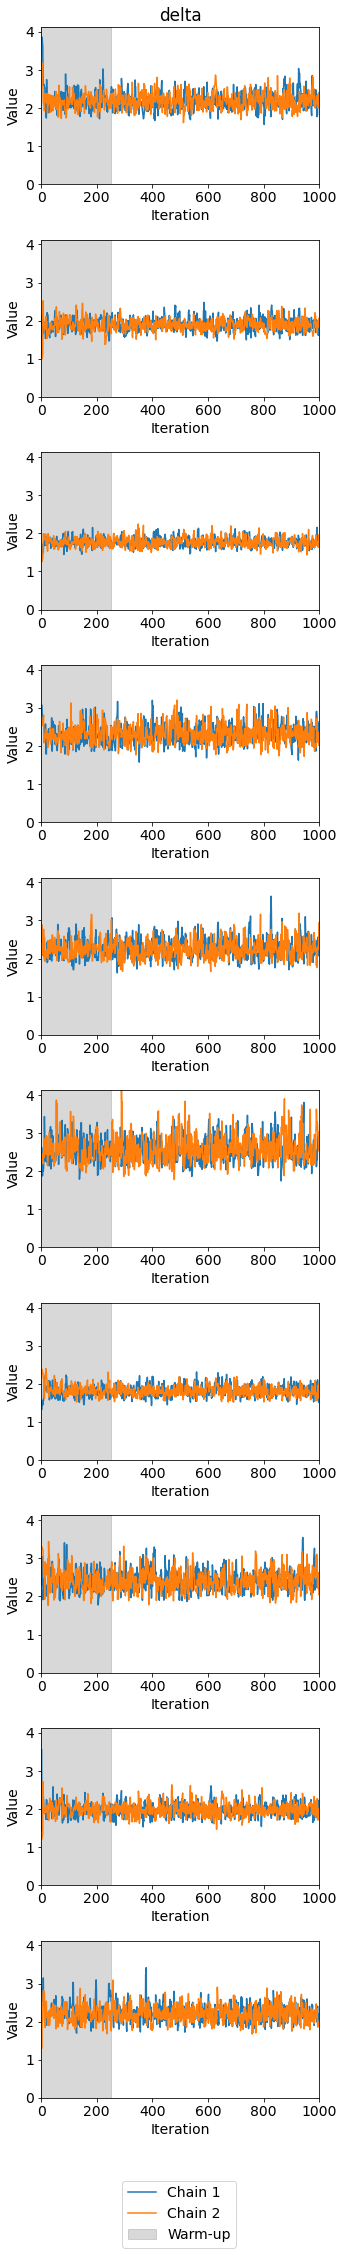

In [27]:
trace_plots(fits, ['delta'], warmup=warmup)

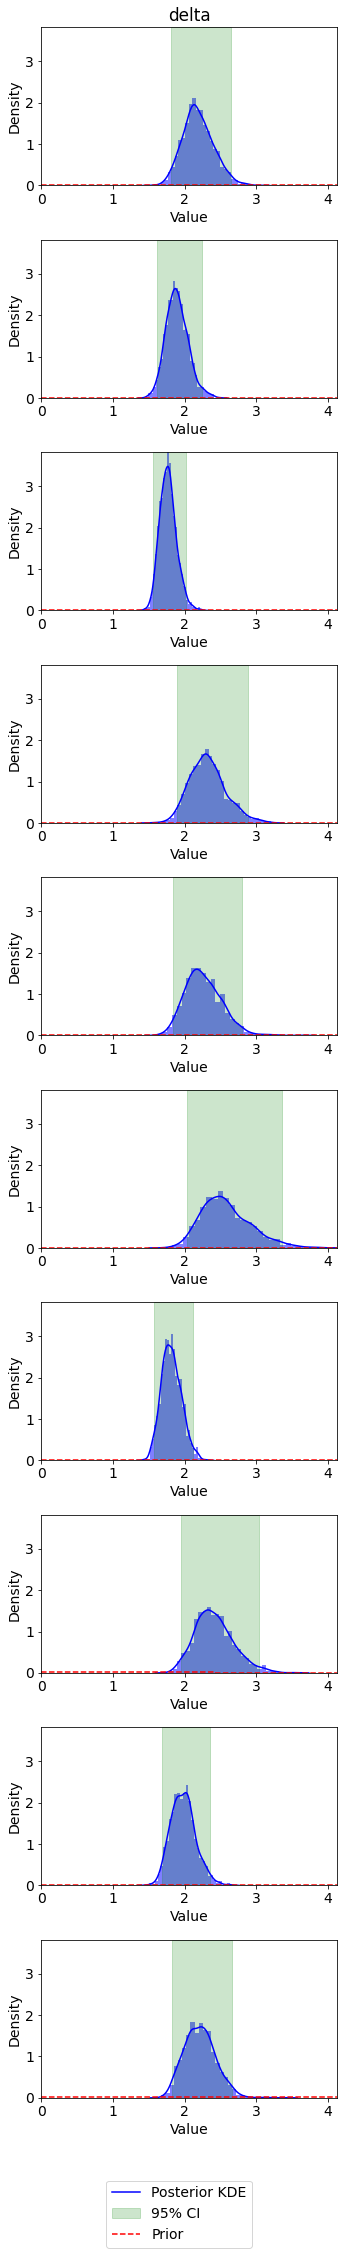

In [28]:
posterior_histograms(fits, ['delta'], [lambda x: expon.pdf(x, scale=1/0.01)])

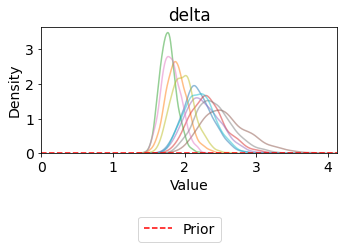

In [29]:
posterior_kdes_overlaid(fits, ['delta'], [lambda x: expon.pdf(x, scale=1/0.01)])

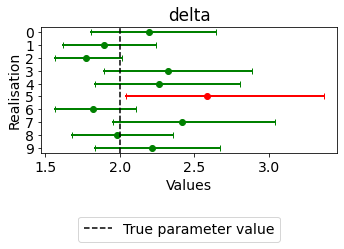

In [30]:
stacked_credible_intervals(fits, ['delta'], [2])

#### max_T=300

In [31]:
max_T = 300
num_samples = 10
hawkes_realisations = []

master_seed = 37789148086743724264404479032151903001
seed_seq_master = np.random.SeedSequence(master_seed)

for i in range(num_samples):

    child_seed = seed_seq_master.spawn(1)[0]

    hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=child_seed)
    hawkes_realisations.append(hawkes_realisation)

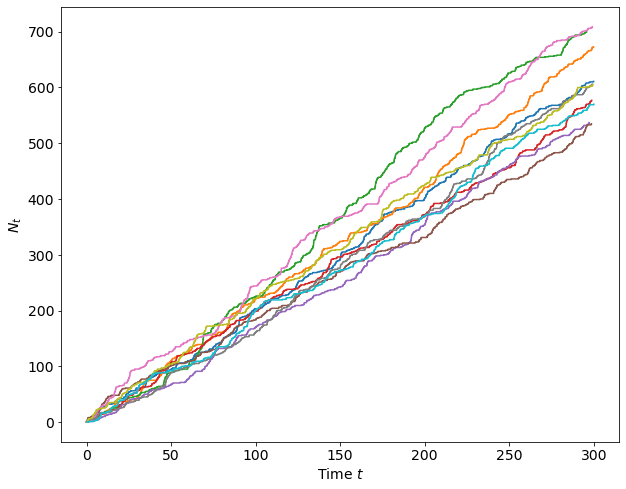

In [32]:
for h in hawkes_realisations:
    h = [0] + h
    counts = np.arange(len(h))
    plt.step(h, counts, where='post')
plt.xlabel("Time $t$")
plt.ylabel("$N_t$")
plt.show()

In [33]:
data_list = [{
    "N" : len(h),
    "events_list" : h,
    "max_T" : max_T
} for h in hawkes_realisations]

In [34]:
warmup = 250

master_seed_stan = 43526238385608073352718321501689842867
seed_seq_master_stan = np.random.SeedSequence(master_seed_stan)

fits = []

save_dir = os.path.join('.', 'saved_fits', 'exponential_priors_delta_only', f'max_T={max_T}')

# for i in range(num_samples):
#     print(f"MCMC sampling for realisation {i}")

#     child_seed_stan = seed_seq_master_stan.spawn(1)[0]

#     # Create a random number generator using the seed
#     rng = np.random.default_rng(child_seed_stan)
    
#     # Generate random integers less than 2**32 - 1
#     child_seed = rng.integers(2**32 - 1)
#     print(f"Child seed used = {child_seed}")

#     save_path = os.path.join(save_dir, f"realisation{i}")
#     print(f"Saving to {save_path}")

#     fit = model_compiled.sample(data=data_list[i],
#                                 seed=child_seed,
#                                 chains=2,
#                                 parallel_chains=2,
#                                 iter_warmup=warmup,
#                                 iter_sampling=3*warmup,
#                                 inits="0",
#                                 save_warmup=True,
#                                 output_dir=save_path)
    
#     fits.append(fit)

In [35]:
for i in range(num_samples):
    save_path = os.path.join(save_dir, f"realisation{i}")
    fit = cmdstanpy.from_csv(save_path)
    fits.append(fit)

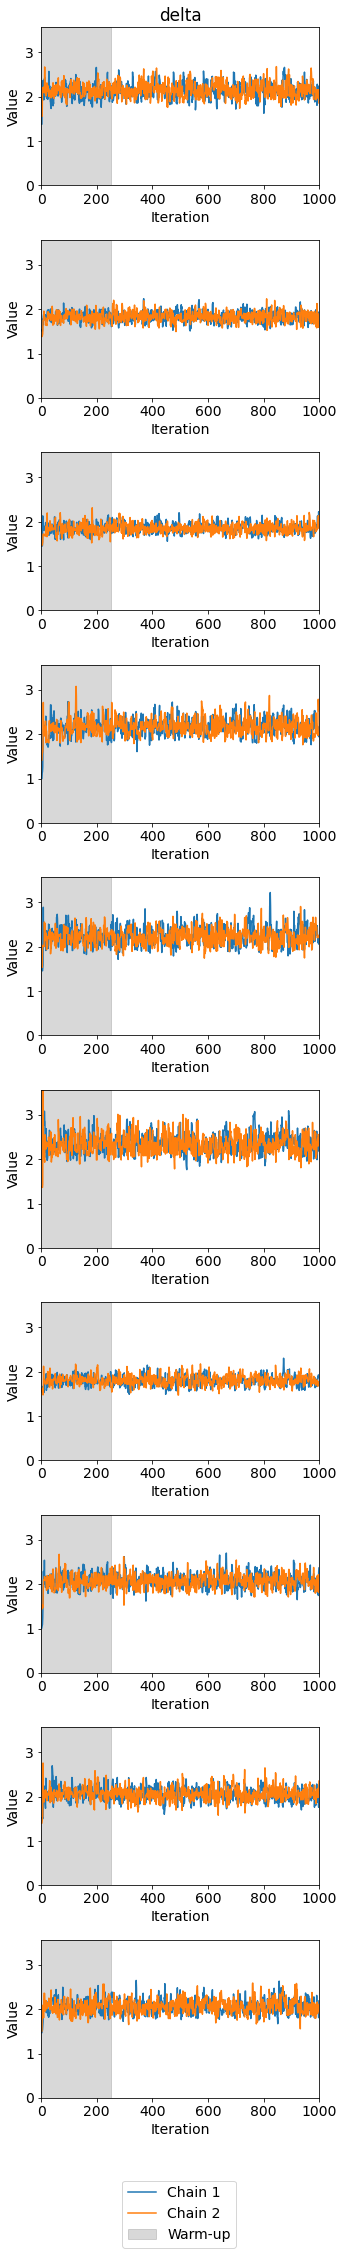

In [36]:
trace_plots(fits, ['delta'], warmup=warmup)

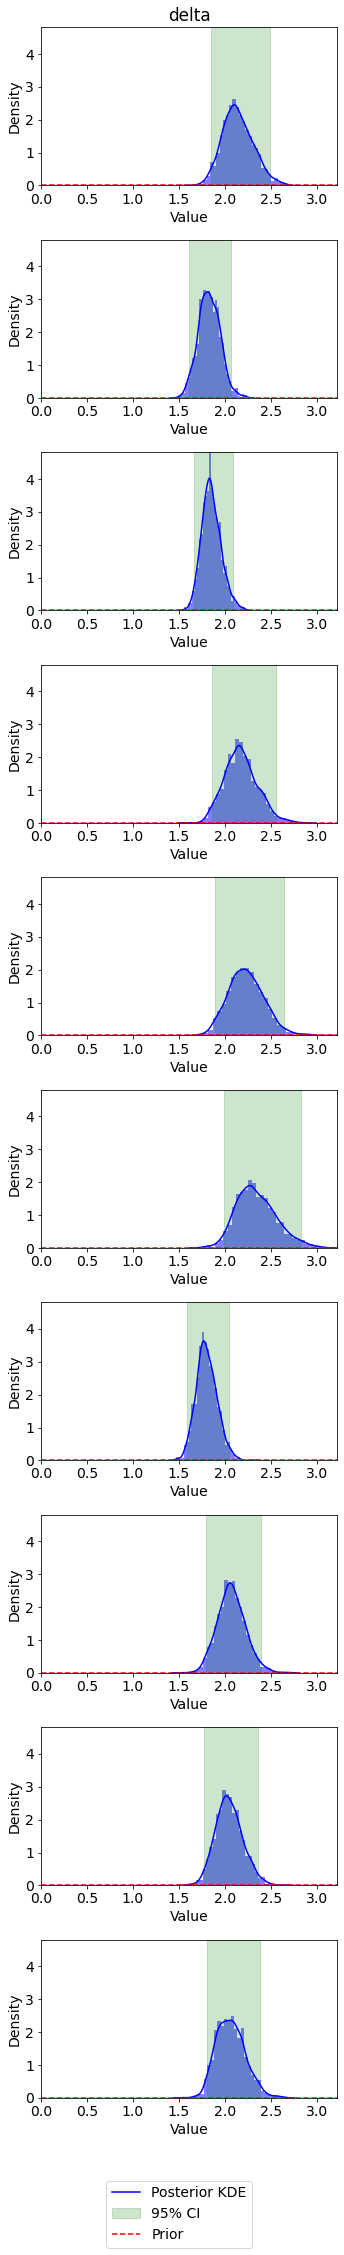

In [37]:
posterior_histograms(fits, ['delta'], [lambda x: expon.pdf(x, scale=1/0.01)])

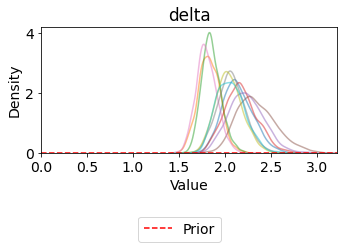

In [38]:
posterior_kdes_overlaid(fits, ['delta'], [lambda x: expon.pdf(x, scale=1/0.01)])

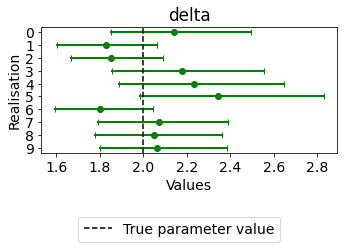

In [39]:
stacked_credible_intervals(fits, ['delta'], [2])

Sidenote: max_T=300 took 45 mins to run.

#### max_T=400

In [40]:
max_T = 400
num_samples = 10
hawkes_realisations = []

master_seed = 37789148086743724264404479032151903001
seed_seq_master = np.random.SeedSequence(master_seed)

for i in range(num_samples):

    child_seed = seed_seq_master.spawn(1)[0]

    hawkes_realisation = sample_hawkes_process_thinning_true_vectorised(max_T, constant_background, exp_kernel_vectorised, seed=child_seed)
    hawkes_realisations.append(hawkes_realisation)

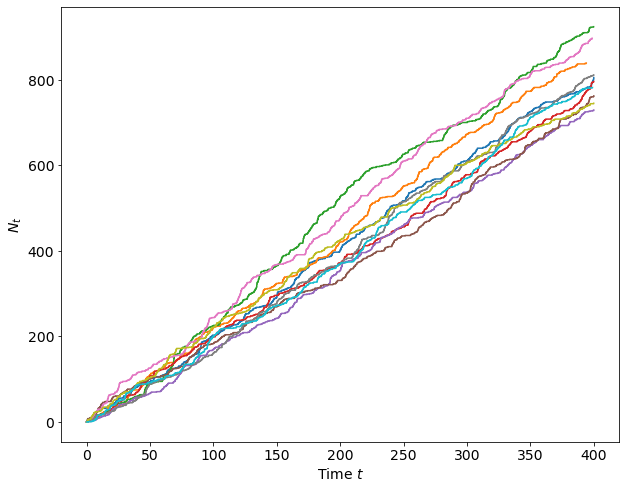

In [41]:
for h in hawkes_realisations:
    h = [0] + h
    counts = np.arange(len(h))
    plt.step(h, counts, where='post')
plt.xlabel("Time $t$")
plt.ylabel("$N_t$")
plt.show()

In [42]:
data_list = [{
    "N" : len(h),
    "events_list" : h,
    "max_T" : max_T
} for h in hawkes_realisations]

In [43]:
warmup = 250

master_seed_stan = 43526238385608073352718321501689842867
seed_seq_master_stan = np.random.SeedSequence(master_seed_stan)

fits = []

save_dir = os.path.join('.', 'saved_fits', 'exponential_priors_delta_only', f'max_T={max_T}')

# for i in range(num_samples):
#     print(f"MCMC sampling for realisation {i}")

#     child_seed_stan = seed_seq_master_stan.spawn(1)[0]

#     # Create a random number generator using the seed
#     rng = np.random.default_rng(child_seed_stan)
    
#     # Generate random integers less than 2**32 - 1
#     child_seed = rng.integers(2**32 - 1)
#     print(f"Child seed used = {child_seed}")

#     save_path = os.path.join(save_dir, f"realisation{i}")
#     print(f"Saving to {save_path}")

#     fit = model_compiled.sample(data=data_list[i],
#                                 seed=child_seed,
#                                 chains=2,
#                                 parallel_chains=2,
#                                 iter_warmup=warmup,
#                                 iter_sampling=3*warmup,
#                                 inits="0",
#                                 save_warmup=True,
#                                 output_dir=save_path)
    
#     fits.append(fit)

In [44]:
for i in range(num_samples):
    save_path = os.path.join(save_dir, f"realisation{i}")
    fit = cmdstanpy.from_csv(save_path)
    fits.append(fit)

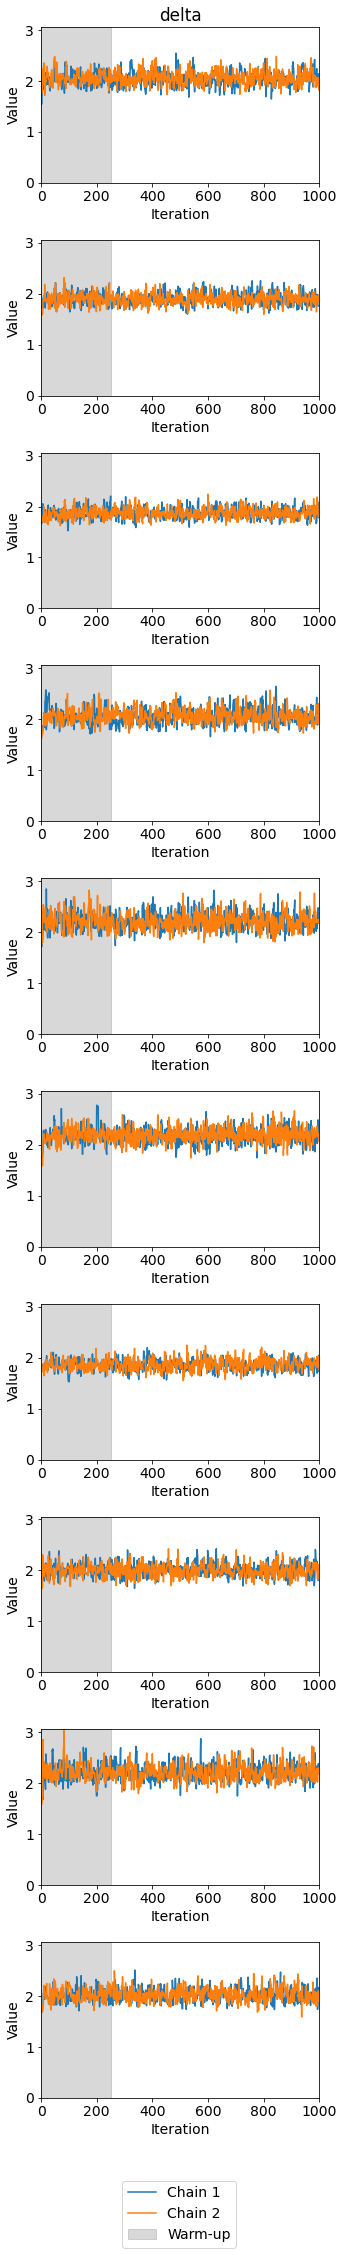

In [45]:
trace_plots(fits, ['delta'], warmup=warmup)

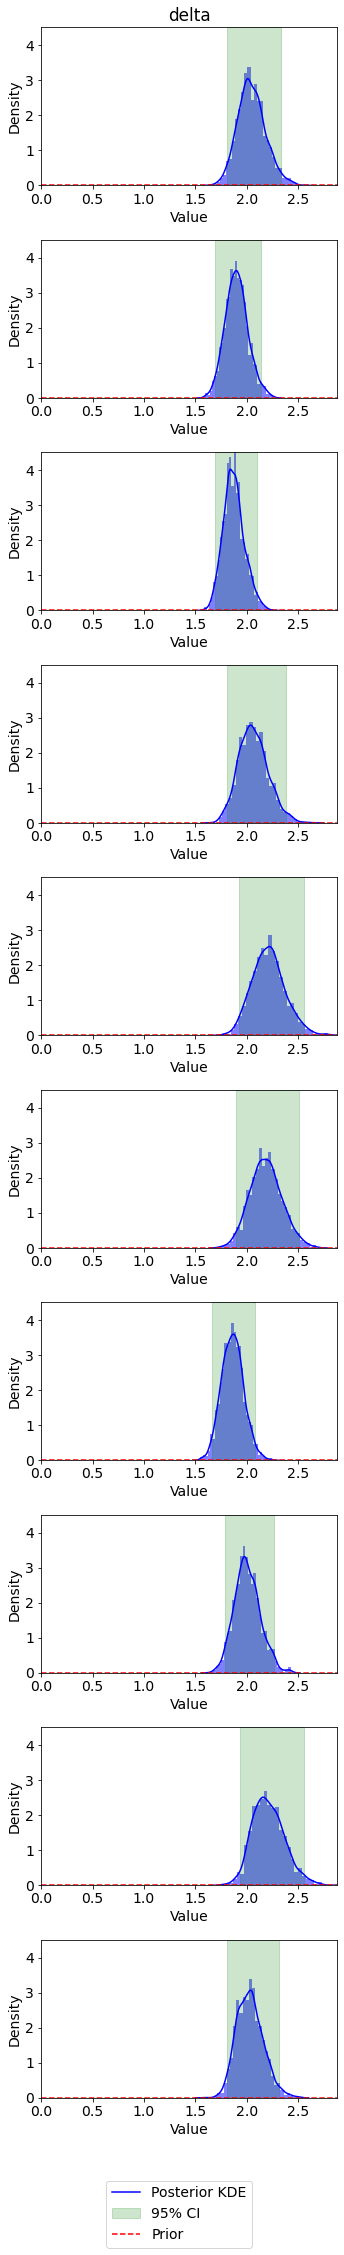

In [46]:
posterior_histograms(fits, ['delta'], [lambda x: expon.pdf(x, scale=1/0.01)])

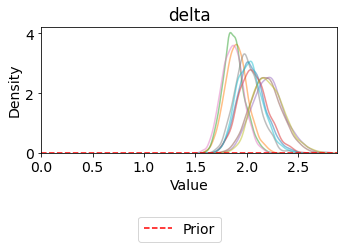

In [47]:
posterior_kdes_overlaid(fits, ['delta'], [lambda x: expon.pdf(x, scale=1/0.01)])

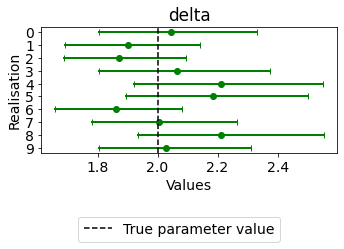

In [48]:
stacked_credible_intervals(fits, ['delta'], [2])

## Summary

Let's try and plot the posteriors of each realisation altogether.

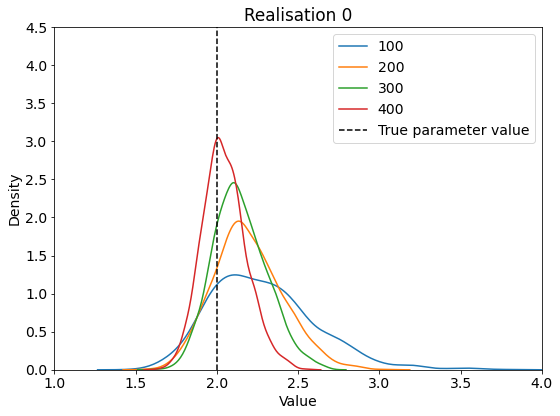

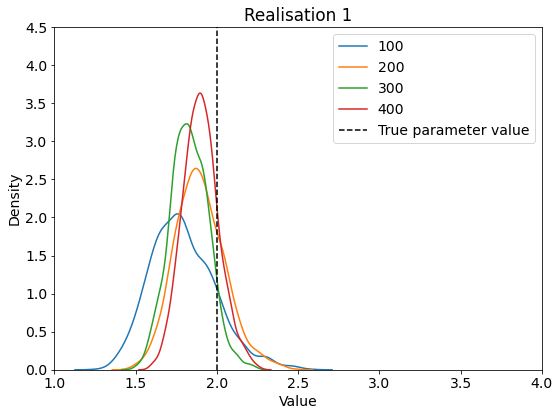

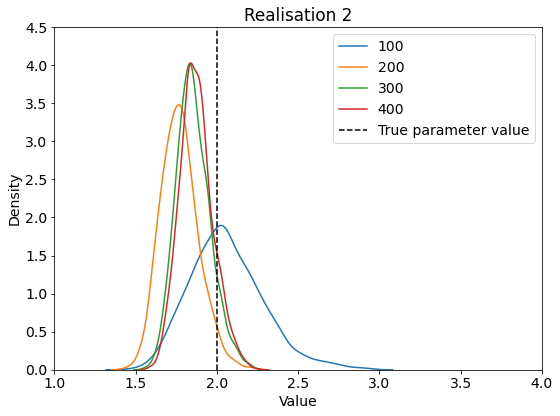

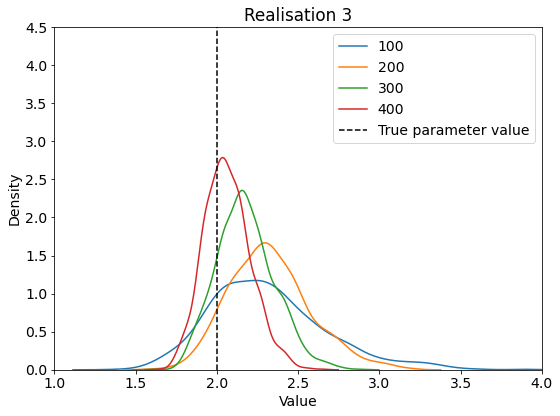

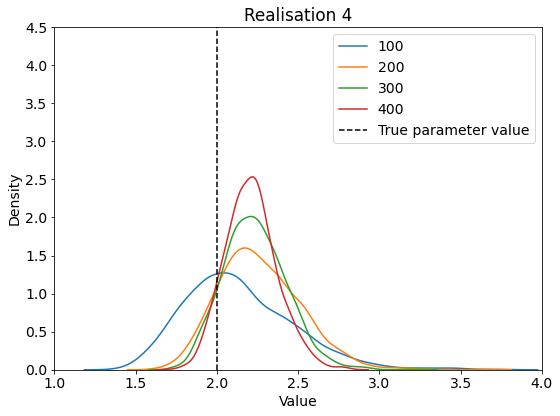

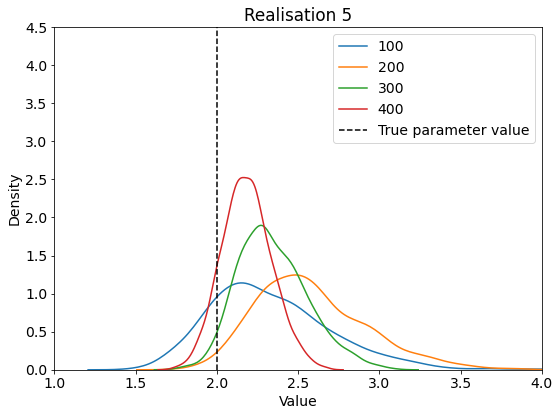

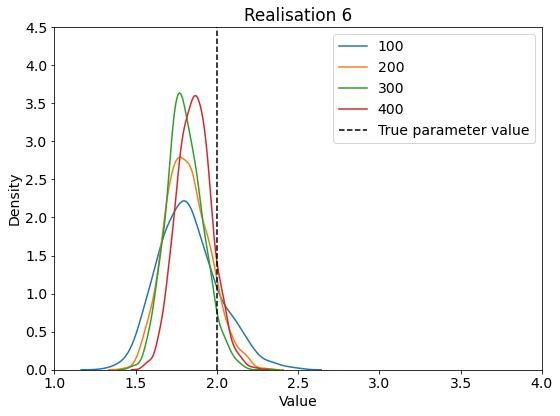

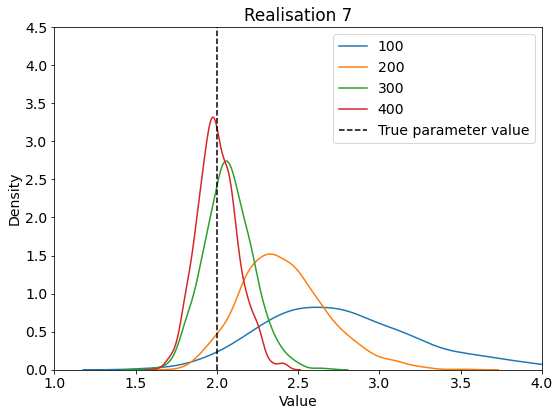

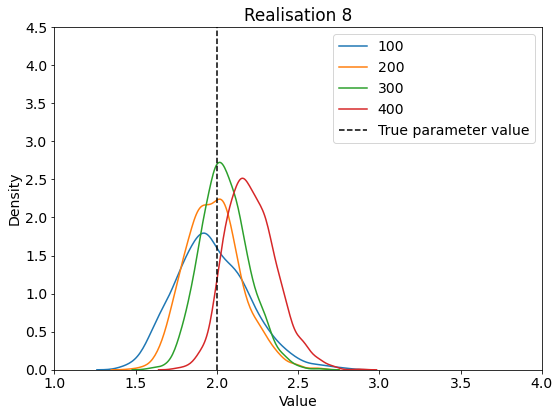

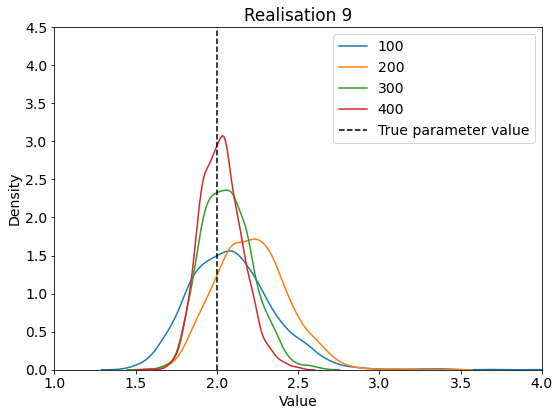

In [101]:
save_plot_dir = r"C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\plots\bayesian\incr_obs_period"
for j in range(10):
    fig, ax = plt.subplots(figsize=(8, 6))
    for i, T in enumerate([100, 200, 300, 400]):
        save_dir = os.path.join('.', 'saved_fits', 'exponential_priors_delta_only', f'max_T={T}')
        save_path = os.path.join(save_dir, f'realisation{j}')
        fit = cmdstanpy.from_csv(save_path)
        df = fit.draws_pd('delta')
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            sns.kdeplot(df.squeeze(), ax=ax, label=T, alpha=1)
    ax.set_xlabel('Value')
    ax.set_title(f"Realisation {j}")
    plt.xlim(1,4)
    plt.ylim(0,4.5)
    plt.axvline(2, color='black', linestyle='--', label='True parameter value')
    plt.legend()
    plt.tight_layout()
    save_plot_path = os.path.join(save_plot_dir, f"realisation_{j}_kde.png")
    plt.savefig(save_plot_path)
    plt.show()
    plt.close(fig)

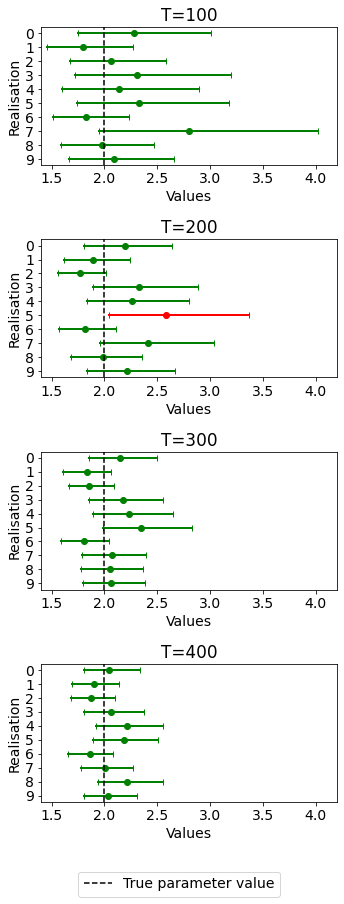

In [60]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(5, 3*4))

for i, T in enumerate([100,200,300,400]):
    save_dir = os.path.join('.', 'saved_fits', 'exponential_priors_delta_only', f'max_T={T}')
    axs_temp = axs[i]
    for j in range(10):
        save_path = os.path.join(save_dir, f'realisation{j}')
        fit = cmdstanpy.from_csv(save_path)
        data = fit.draws_pd('delta')

        mean = np.mean(data)
        credible_interval = stats.mstats.mquantiles(data, [0.025, 0.975])

        if credible_interval[0] <= 2 <= credible_interval[1]:
            color_temp = 'green'
        else:
            color_temp = 'red'

        axs_temp.scatter(mean, j, color=color_temp)
        axs_temp.plot(credible_interval, [j, j], color=color_temp, linestyle='-', linewidth=2, marker='|')
    axs_temp.axvline(2, color='black', linestyle='--', label='True parameter value')
    axs_temp.invert_yaxis()
    axs_temp.set_title(f"T={T}")
    axs_temp.set_xlabel('Values')
    axs_temp.set_yticks(np.arange(10))
    axs_temp.set_ylabel('Realisation')
    axs_temp.set_xlim(1.4, 4.2)
handles, labels = axs_temp.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, -0.01), ncol=1)
    
plt.tight_layout()
plt.show()